In [22]:
import os
import torch
import argparse
import numpy as np

from engine.logger import Logger
from engine.solver import Trainer
from Data.build_dataloader import build_dataloader, build_dataloader_cond
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one
from Utils.io_utils import load_yaml_config, seed_everything, merge_opts_to_config, instantiate_from_config
from Utils.metric_utils import visualization

import sys
import time
import torch.nn as nn

from pathlib import Path
from tqdm import tqdm
from ema_pytorch import EMA
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from Utils.io_utils import instantiate_from_config, get_model_parameters_info


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman') 

import umap                         
import seaborn as sns 
from tqdm import tqdm
from einops import reduce

In [23]:
def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Training Script')
    parser.add_argument('--name', type=str, default=None)

    parser.add_argument('--config_file', type=str, default=None, 
                        help='path of config file')
    parser.add_argument('--output', type=str, default='OUTPUT', 
                        help='directory to save the results')
    parser.add_argument('--tensorboard', action='store_true', 
                        help='use tensorboard for logging')

    # args for random

    parser.add_argument('--cudnn_deterministic', action='store_true', default=False,
                        help='set cudnn.deterministic True')
    parser.add_argument('--seed', type=int, default=10, 
                        help='seed for initializing training.')
    parser.add_argument('--gpu', type=int, default=None,
                        help='GPU id to use. If given, only the specific gpu will be'
                        ' used, and ddp will be disabled')
    
    # args for training
    parser.add_argument('--train', action='store_true', default=False, help='Train or Test.')
    parser.add_argument('--sample', type=int, default=0, 
                        choices=[0, 1], help='Condition or Uncondition.')
    parser.add_argument('--mode', type=str, default='infill',
                        help='Infilling or Forecasting.')
    parser.add_argument('--milestone', type=int, default=10)

    parser.add_argument('--missing_ratio', type=float, default=0., help='Ratio of Missing Values.')
    parser.add_argument('--pred_len', type=int, default=0, help='Length of Predictions.')
    
    
    # args for modify config
    parser.add_argument('opts', help='Modify config options using the command-line',
                        default=None, nargs=argparse.REMAINDER)  

    args = parser.parse_args(args=[])
    args.save_dir = os.path.join(args.output, f'{args.name}')

    return args


In [24]:

args = parse_args()

data_name = 'SP500'
# data_name = 'ETTh1'
# data_name = 'ER'
# data_name = 'Energy'
# data_name = 'weather'


if data_name == 'SP500':
    args.config_file =  './Config/SP500.yaml'

elif data_name == 'ER':
    args.config_file =  './Config/exchange_rate.yaml'
    
elif data_name == 'ETTh1':
    args.config_file =  './Config/ETTh1.yaml'

elif data_name == 'Energy':
    args.config_file =  './Config/Energy.yaml'
    
elif data_name == 'weather':
    args.config_file =  './Config/weather.yaml'
    
elif data_name == 'MuJoCo':
    args.config_file =  './Config/MuJoCo.yaml'
    

# args.config_file =  './Config/stocks.yaml'

args.gpu =  0
args.train = True
print(args)

Namespace(name=None, config_file='./Config/SP500.yaml', output='OUTPUT', tensorboard=False, cudnn_deterministic=False, seed=10, gpu=0, train=True, sample=0, mode='infill', milestone=10, missing_ratio=0.0, pred_len=0, opts=[], save_dir='OUTPUT\\None')


In [25]:
if args.seed is not None:
    seed_everything(args.seed)

if args.gpu is not None:
    torch.cuda.set_device(args.gpu)

config = load_yaml_config(args.config_file)
config = merge_opts_to_config(config, args.opts)


config['dataloader']['batch_size'] = 128
print(config)

beta_schedule = config['model']['params']['beta_schedule'] 
timesteps = config['model']['params']['timesteps'] 
print(beta_schedule, timesteps)

Global seed set to 10
{'model': {'target': 'Models.interpretable_diffusion.gaussian_diffusion.Diffusion_TS', 'params': {'seq_length': 30, 'feature_size': 6, 'n_layer_enc': 2, 'n_layer_dec': 2, 'd_model': 64, 'timesteps': 500, 'sampling_timesteps': 500, 'loss_type': 'l1', 'beta_schedule': 'cosine', 'n_heads': 4, 'mlp_hidden_times': 4, 'attn_pd': 0.0, 'resid_pd': 0.0, 'kernel_size': 1, 'padding_size': 0}}, 'solver': {'base_lr': 1e-05, 'max_epochs': 10000, 'results_folder': './Checkpoints_stock', 'gradient_accumulate_every': 2, 'save_cycle': 500, 'ema': {'decay': 0.995, 'update_interval': 10}, 'scheduler': {'target': 'engine.lr_sch.ReduceLROnPlateauWithWarmup', 'params': {'factor': 0.5, 'patience': 2000, 'min_lr': 1e-05, 'threshold': 0.1, 'threshold_mode': 'rel', 'warmup_lr': 0.0008, 'warmup': 500, 'verbose': False}}}, 'dataloader': {'train_dataset': {'target': 'Utils.Data_utils.real_datasets.CustomDataset', 'params': {'name': 'stock', 'proportion': 1.0, 'data_root': './Data/datasets/stoc

In [26]:
logger = Logger(args)
logger.save_config(config)

In [27]:
model = instantiate_from_config(config['model']).cuda()
# print(model)
print(model.use_ff, model.num_timesteps, model.loss_type)
print(model.sampling_timesteps, model.fast_sampling)
# print(model.model)


True 500 l1
500 False


In [28]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

if data_name == 'SP500':
    load_data = np.load( './Data/datasets/sp500.npy')

elif data_name == 'ER':
    load_data = np.load( './Data/datasets/exchange_rate.npy')

elif data_name == 'ETTh1':
    load_data = np.load( './Data/datasets/ETTh1.npy')
    
elif data_name == 'Energy':
    load_data = np.load( './Data/datasets/Energy.npy')
    
elif data_name == 'weather':
    load_data = np.load( './Data/datasets/weather.npy')

elif data_name == 'MuJoCo':
    load_data = np.load( './Data/datasets/MuJoCo.npy')
    
    
np.random.shuffle(load_data)
train_data = load_data


Numble = train_data.shape[0]
Length = train_data.shape[1]
Feature = train_data.shape[2]
Batchsize = 128


class MyDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)  
        return x   
                    
dataset = MyDataset(train_data)    
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

def cycle(dl):         
    while True:
        for data in dl:
            yield data
            
dl = cycle( dataloader )
print( next(dl).shape )

torch.Size([128, 30, 6])


In [29]:
device = model.betas.device
step = 0

train_num_steps = 20000
gradient_accumulate_every = config['solver']['gradient_accumulate_every'] 


In [30]:
start_lr = config['solver'].get('base_lr', 1.0e-4)
ema_decay = config['solver']['ema']['decay']
ema_update_every = config['solver']['ema']['update_interval']
ema = EMA(model, beta=ema_decay, update_every=ema_update_every).to(device)
opt = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=start_lr, betas=[0.9, 0.96])
sc_cfg = config['solver']['scheduler']
sc_cfg['params']['optimizer'] = opt    
sch = instantiate_from_config(sc_cfg)   

In [31]:
model = instantiate_from_config(config['model']).cuda()

model.load_state_dict(torch.load( "./checkpoint/sp500.pth"  ))
ema.load_state_dict(torch.load( "./checkpoint/sp500_ema.pth"  ))

# model.load_state_dict(torch.load( "./checkpoint/ETTh1.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/ETTh1_ema.pth"  ))

# model.load_state_dict(torch.load( "./checkpoint/ER.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/ER_ema.pth"  ))


# model.load_state_dict(torch.load( "./checkpoint/Energy.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/Energy_ema.pth"  ))

# model.load_state_dict(torch.load( "./checkpoint/weather.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/weather_ema.pth"  ))

# model.load_state_dict(torch.load( "./checkpoint/MuJoCo.pth"  ))
# ema.load_state_dict(torch.load( "./checkpoint/MuJoCo_ema.pth"  ))



<All keys matched successfully>

In [32]:
from Models.interpretable_diffusion.model_utils import default, identity, extract
from Models.interpretable_diffusion.gaussian_diffusion import linear_beta_schedule, cosine_beta_schedule, Diffusion_TS
import torch.nn.functional as F


shape = (Numble, Length, Feature)
print(shape)

num_timesteps = model.num_timesteps
print(num_timesteps)


if beta_schedule == 'linear':
    betas = linear_beta_schedule(num_timesteps)
elif beta_schedule == 'cosine':
    betas = cosine_beta_schedule(num_timesteps)
            
        
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)
print(betas.shape)

print(betas[0:10])
print(betas[0:10].to(torch.float32))

(5775, 30, 6)
500
torch.Size([500])
tensor([8.7424e-05, 1.0685e-04, 1.2629e-04, 1.4572e-04, 1.6516e-04, 1.8459e-04,
        2.0404e-04, 2.2348e-04, 2.4293e-04, 2.6239e-04], dtype=torch.float64)
tensor([8.7424e-05, 1.0685e-04, 1.2629e-04, 1.4572e-04, 1.6516e-04, 1.8459e-04,
        2.0404e-04, 2.2348e-04, 2.4293e-04, 2.6239e-04])


In [33]:
betas = betas.to(torch.float32).cuda()
alphas = alphas.to(torch.float32).cuda()
alphas_cumprod = alphas_cumprod.to(torch.float32).cuda()
alphas_cumprod_prev = alphas_cumprod_prev.to(torch.float32).cuda()

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(torch.float32).cuda()
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod).to(torch.float32).cuda()
log_one_minus_alphas_cumprod = torch.log(1. - alphas_cumprod).to(torch.float32).cuda()
sqrt_recip_alphas_cumprod =  torch.sqrt(1. / alphas_cumprod).to(torch.float32).cuda()
sqrt_recipm1_alphas_cumprod =  torch.sqrt(1. / alphas_cumprod - 1).to(torch.float32).cuda()


# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod).cuda()

# above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
posterior_variance = posterior_variance.to(torch.float32).cuda()

posterior_log_variance_clipped = torch.log(posterior_variance.clamp(min=1e-20)).to(torch.float32).cuda()
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod).to(torch.float32).cuda()
posterior_mean_coef2 =  (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod).to(torch.float32).cuda()

# calculate reweighting
loss_weight =  ( torch.sqrt(alphas) * torch.sqrt(1. - alphas_cumprod) / betas / 100).to(torch.float32).cuda()


print(sqrt_alphas_cumprod.shape, posterior_variance.shape )

torch.Size([500]) torch.Size([500])


In [34]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.bernoulli import Bernoulli


class classify(nn.Module ):
    def __init__(self, D):
        super(classify, self).__init__()
        self.logits_layer = nn.Sequential(
                                          nn.Linear(D, D),  

                                         nn.Tanh(),   
            
                                         nn.Linear(D, D),
                                        )
                                                                                
    
    def forward(self, l_out_mixed ):
        
        logits = self.logits_layer(l_out_mixed)      
        p_s_given_x = Bernoulli(logits=logits)
        
        return p_s_given_x
    
def introduce_missing_superior_to_mean(X):
    print("Introducing missing data with > mean")
    N, D = X.shape
    Xnan = X.copy()

    # ---- MNAR in D/2 dimensions
    mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
    ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean
    Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan

    Xnan = Xnan.astype(np.float32)
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan.astype(np.float32))] = 0

    return Xnan, Xz


def introduce_missing_mean_values(X, percentage_to_remove = 30):
    print("Introduce missing data by removing the values around the mean")
    N, D = X.shape
    Xnan = X.copy()

    num_elements = int(N * percentage_to_remove / 100)   # number of elements to remove

    # ---- MNAR in D/2 dimensions
    mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
    abs_diff_from_mean = np.abs(Xnan[:, :int(D / 2)] - mean)
    indices_to_remove = np.argsort(abs_diff_from_mean, axis = 0)[:num_elements]
    # Set those values to NaN
    for d in range(indices_to_remove.shape[1]):
        Xnan[indices_to_remove[:, d], d] = np.nan
    Xnan = Xnan.astype(np.float32)
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0
    return Xnan, Xz


def introduce_missing_extreme_values(X, percentile_extreme = 25):
    print("Introducing missing data via removing extreme values")
    N, D = X.shape
    Xnan = X.copy()

    # ---- MNAR in D/2 dimensions
    lower_bound = np.percentile(Xnan[:, :int(D / 2)], percentile_extreme, axis=0)
    upper_bound = np.percentile(Xnan[:, :int(D / 2)], 100 - percentile_extreme, axis=0)

    ix_lower = Xnan[:, :int(D / 2)] < lower_bound
    ix_higher = Xnan[:, :int(D / 2)] > upper_bound
    Xnan[:, :int(D / 2)][ix_lower | ix_higher] = np.nan  
    Xnan = Xnan.astype(np.float32)
    
    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0    

    return Xnan, Xz




X_data = load_data.reshape(-1, Numble*Length,Feature).squeeze(0)

Xnan, Xz = introduce_missing_mean_values( X_data)
# Xnan, Xz = introduce_missing_superior_to_mean( X_data)
# Xnan, Xz = introduce_missing_extreme_values( X_data)

Xnan = Xnan.reshape(-1, Length, Feature)
S = np.array(~np.isnan(Xnan), dtype=np.float32)
print(S.shape)

n_1 = np.sum(S == 1)
n_0 = np.sum(S == 0)
print(n_0/(n_1+n_0))


Introduce missing data by removing the values around the mean
(5775, 30, 6)
0.15


In [35]:
x = torch.tensor(X_data.reshape(-1, Length, Feature), dtype=torch.float32, device=device) 
s = torch.tensor(S, dtype=torch.float32, device=device) 
print(x.shape, s.shape)

train_dataset = TensorDataset(x, s ) 
train_loader  = DataLoader(train_dataset, batch_size=1000, shuffle=True)

classi = classify(D=Feature).to(device)
optimizer = optim.Adam( list(classi.parameters()), lr=0.0001)


torch.Size([5775, 30, 6]) torch.Size([5775, 30, 6])


In [36]:
classi = classify(D=Feature).to(device)
classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/sp500_rm_around_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/sp500_rm_superior_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/sp500_rm_extre_val.pth"  ))

# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ETT_rm_around_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ETT_rm_superior_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ETT_rm_extre_val.pth"  ))

# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ER_rm_around_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ER_rm_superior_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/ER_rm_extre_val.pth"  ))

# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Energy_rm_around_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Energy_rm_superior_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Energy_rm_extre_val.pth"  ))

# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Weather_rm_around_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Weather_rm_superior_mean_val.pth"  ))
# classi.load_state_dict(torch.load( "./checkpoint/mnar_classifier/Weather_rm_extre_val.pth"  ))

<All keys matched successfully>

In [37]:
test_data = torch.tensor(X_data.reshape(-1,Length, Feature), dtype=torch.float32, device=device) 
test_s = torch.tensor(s, dtype=torch.float32, device=device)
print(test_data.shape, test_s.shape)


p_s_given_x = classi(test_data)
p = p_s_given_x.log_prob(test_s).exp()
print(p.mean(), test_s.dtype)

mask_data = S.astype(bool)

torch.Size([5775, 30, 6]) torch.Size([5775, 30, 6])
tensor(0.9928, device='cuda:0', grad_fn=<MeanBackward0>) torch.float32


C:\Users\PC123\AppData\Local\Temp\ipykernel_14280\2098842402.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_s = torch.tensor(s, dtype=torch.float32, device=device)


In [38]:
class MyDataset(Dataset):
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data

    def __len__(self):
        return len(self.X_data)
    

    def __getitem__(self, idx):
        x = torch.tensor(self.X_data[idx], dtype=torch.float32)    
        y = torch.tensor(self.Y_data[idx])                         
        
        return x, y   
             
dataset_with_mask = MyDataset(load_data[0:500], mask_data[0:500] )    

dataloader_with_mask = DataLoader(dataset_with_mask, batch_size=500, shuffle=True)
print( len( next(iter(dataloader_with_mask)) ) )
print(next(iter(dataloader_with_mask))[0].shape)
print(next(iter(dataloader_with_mask))[1].shape)

2
torch.Size([500, 30, 6])
torch.Size([500, 30, 6])


# MAP-not 

In [41]:
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import copy


sampling_steps =  num_timesteps
shape = (Length, Feature)
padding_masks = None
clip_x_start = False
clip_denoised = True

samples = np.empty([0, shape[0], shape[1]])
reals = np.empty([0, shape[0], shape[1]])
masks = np.empty([0, shape[0], shape[1]])    

torch.manual_seed(0)

ema.ema_model.model.eval()
classi.eval()


loss1_list = []
loss2_list = []
loss3_list = []
loss_list = []



for idx, (x, t_m) in  enumerate(dataloader_with_mask):    
    x, t_m = x.to(device), t_m.to(device)
    partial_mask = t_m   
    target = x*t_m                                  
    xt1 = torch.randn(x.shape, device=device)                                     
    xt = xt1            


    for t in tqdm(reversed(range(0, num_timesteps)), desc='DPS loop'):
        ori_t = t
        batched_times = torch.full((xt.shape[0],), t, device=x.device, dtype=torch.long)
        t = batched_times

        if padding_masks is None:
            padding_masks = torch.ones(x.shape[0], Length, dtype=bool, device=x.device)

        maybe_clip = partial(torch.clamp, min=-1., max=1.) if clip_x_start else identity

        trend, season = ema.ema_model.model(xt, t, padding_masks=padding_masks)  
        x_start = trend + season 
        x_start = maybe_clip(x_start)

        pred_noise = ( extract(sqrt_recip_alphas_cumprod, t, xt.shape ) * xt - x_start) /  extract(sqrt_recipm1_alphas_cumprod, t, xt.shape) 

        if clip_denoised:
            x_start.clamp_(-1., 1.)
            
    
        mask_temp = partial_mask.to(torch.float32)  

        temp = copy.deepcopy(x_start)
        code_x =  Variable( temp, requires_grad=True ) 
    

        optimizer = torch.optim.Adam( [code_x], lr=0.0005 )  
    
    
        if ori_t >= 0:

            for i in range(10):             

                loss1 = torch.linalg.norm( code_x - x_start )     

                loss2 = code_x * mask_temp - target* mask_temp      
                loss2 = torch.linalg.norm( loss2 )


                p_s_given_x = classi(code_x)
                p = p_s_given_x.log_prob( mask_temp )                     
                loss3 = ( p* (1-mask_temp) ).sum()/(1-mask_temp).sum()        

                
                '========= choose the hyper-parameters according to table ======= '

                loss = loss1 + 2 * loss2 - 3 * loss3    
            
                loss.backward() 
                optimizer.step()
                optimizer.zero_grad() 

                loss1_list.append(loss1.item() )
                loss2_list.append(loss2.item() )
                loss3_list.append(loss3.item() )
                loss_list.append(loss.item() )
            
            
        if ori_t >= 1:        # 最后一次不加噪
            noise_t = ori_t-1
        
            batched_times = torch.full((xt.shape[0],), noise_t, device=x.device, dtype=torch.long)
            t = batched_times

            noise = torch.randn_like(code_x)

            xt_1 = extract(sqrt_alphas_cumprod, t, code_x.shape) * code_x  +  extract(sqrt_one_minus_alphas_cumprod, t, code_x.shape) *  pred_noise 

            xt = xt_1.detach_() 
        else: 

            xt = code_x.detach_() #
    

    xt[partial_mask] = target[partial_mask]  
    samples = np.row_stack([samples, xt.detach().cpu().numpy()])
    reals = np.row_stack([reals, x.detach().cpu().numpy()])
    masks = np.row_stack([masks, t_m.detach().cpu().numpy()])

DPS loop: 500it [00:13, 37.47it/s]


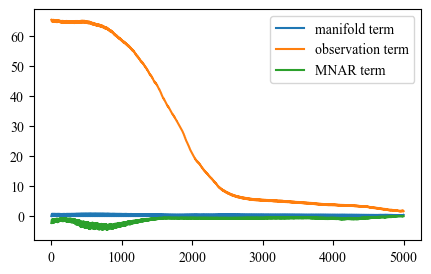

In [19]:
plt.figure(figsize=(5, 3))
plt.plot(loss1_list,label='manifold term')
plt.plot(loss2_list,label='observation term')
plt.plot(loss3_list,label='MNAR term')
# plt.plot(loss_list)
# plt.show()
plt.legend()


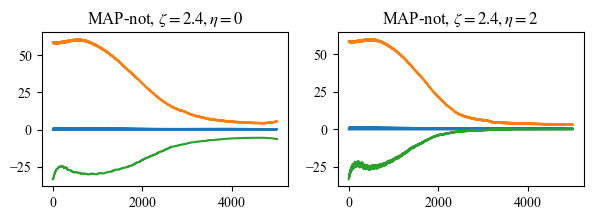

In [151]:

from matplotlib import rcParams
config = {
    "font.family":'times new roman',
    "font.size": 10,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'], 
}

rcParams.update(config)

# a1 = loss1_list
# b1 = loss2_list
# c1 = loss3_list


a2 = loss1_list
b2 = loss2_list
c2 = loss3_list

plt.figure(figsize=(7, 2))
plt.subplot(1,2,1)
plt.plot(a1,label='manifold term')
plt.plot(b1,label='observation term')
plt.plot(c1,label='MNAR term')
plt.title( r"MAP-not, $ \zeta=2.4, \eta=0  $")

plt.subplot(1,2,2)
plt.plot(a2,label='manifold term')
plt.plot(b2,label='observation term')
plt.plot(c2,label='MNAR term')
plt.title( r"MAP-not, $ \zeta=2.4, \eta=2  $")

# plt.legend(fontsize=8)
# plt.savefig('./超参数.pdf')

In [42]:
from pypots.utils.metrics import calc_mse,calc_rmse,calc_mae

rmse = calc_rmse(samples, reals, 1-masks)
mae = calc_mae(samples, reals, 1-masks)  
print(round(rmse,4), round(mae,4) )

0.0064 0.004
